## In this notebook: Figs 6F, S8
f-o differences analyzed by map

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
plt.style.use("article.mplstyle")


import mne

from statannotations.Annotator import Annotator
import itertools

import glob
import os
import sys
from scipy.io import savemat, loadmat
from scipy.stats import pearsonr, spearmanr
from statsmodels.stats.multitest import fdrcorrection
import scipy.stats as stats


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import*
mne.set_log_level('CRITICAL')

In [2]:
#######
#SET UP DIRECTORIES AND PARAMETERS

erp_times = create_erp_times(-0.5,0.5, 128)
ep_path = '../analysis_error/error_epochs_data_n05to05_30Hz_corrected'
mapchange_path = '../analysis_error/mapchange_csv_corrected_since_bymap_till'

good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()
subjects_to_process = good_error_subjects
print(subjects_to_process)

#time points to consider
time_to_plot = [0.08, 0.12] #N100
# time_to_plot = [0.025, 0.06] #P50
time_idx = time_index_custom(time_to_plot, erp_times)

#find either max, min, or peak to peak
if time_to_plot == [0.08, 0.12]:
    peak = np.min 
elif time_to_plot ==[0.025, 0.06]
    peak = np.max

ch_to_plot = ['Cz', 'FCz', 'Fz', 'C1', 'FC1', 'F1', 'F2', 'FC2', 'C2']

['01', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']


In [3]:
######
# Load data into dataframes, one each for first and other keystrokes
# Each row is a keystroke, amplitude is mean of channels at chosen peak of time window


ch_idx = ch_index(ch_to_plot)
periods = ['pre', 'post']

data_f = []
data_o = []

for k, sub in enumerate(subjects_to_process):
    for period in periods:

        # Read epochs data
        ep_file = os.path.join(ep_path, f'error_epochs_all_{period}_{sub}.fif')
        eps = mne.read_epochs(ep_file).get_data()

        # Read mapchange data
        mapchange_file = os.path.join(mapchange_path, f'mapchange_keystrokes_{period}_{sub}.csv')
        mapchange_df = pd.read_csv(mapchange_file)
        mapchange_df_firsts = mapchange_df.query('type =="first"')
        mapchange_df_others = mapchange_df.query('type =="other"')


        #extrct amplitudes of interest for first and other keystrokes
        #try except block in case of index errors (because some keystrokes were registered but are at the end of the recording so not long enough to epoch)
            #these keystrokes are skipped
        #add to dataframe for the first keystrokes
        for i, row in mapchange_df_firsts.iterrows():
            try:
                keystroke_idx = row['keystroke_idx']
                prev_keystrokes = row['prev_keystrokes']
                map_type = row['map']
                prevmap_type = row['prev_map']
                #amp = np.mean(eps[keystroke_idx, ch_idx, time_idx]) #include multiple channels and single timepoint
                #amp = np.min(eps[keystroke_idx, ch_idx, time_idx[0]:time_idx[1]]) #include multiple timepoint and single channel
                amp = peak(eps[keystroke_idx, ch_idx, time_idx[0]:time_idx[1]].mean(axis = 1)) #include multiple time points and multiple channels
                data_f.append({
                    'subject': sub,
                    'period': period,
                    'epochtype': 'first',
                    'prev_keystrokes': prev_keystrokes,
                    'amp_f': amp, 
                    'map_type': map_type,
                    'prevmap_type': prevmap_type
                })
                
                

            except IndexError: 
                print(f'Index error in first keystrokes for {sub}')
                continue
        
        #add to dataframe for the other keystrokes
        for i, row in mapchange_df_others.iterrows():
            try:
                keystroke_idx = row['keystroke_idx']
                map_type = row['map']
                prevmap_type = row['prev_map']
                amp = peak(eps[keystroke_idx, ch_idx, time_idx[0]:time_idx[1]].mean(axis = 1))
                data_o.append({
                    'subject': sub,
                    'period': period,
                    'epochtype': 'other',
                    'prev_keystrokes': -1,
                    'amp_o': amp,
                    'map_type': map_type,
                    'prevmap_type': prevmap_type
                    })
                
            
            except IndexError:
                print(f'Index error in other keystrokes for {sub} {period}')
                continue 

#f_df and o_df are dataframes for first and other keystrokes respectively
f_df = pd.DataFrame(data_f)
o_df = pd.DataFrame(data_o)

Index error in other keystrokes for 04 post
Index error in other keystrokes for 17 post


In [4]:
# get average erp for others so that they can be subtracted from the firsts
periods =['pre', 'post']
data_o_ave = []
for sub in subjects_to_process:
    for period in periods:
        o_df_sub = o_df.query(f'subject == "{sub}" and period == "{period}"')
        aveamp = o_df_sub['amp_o'].mean()
    
        data_o_ave.append(
            {'subject': sub,
            'period': period,
            'aveamp_o': aveamp}
        )

data_o_ave = pd.DataFrame(data_o_ave)

In [5]:
#find average first - other difference by map and period
#only in the average of others in the same map (or meeting the criteria for map entered/left)

maps_to_process =['inv', 'shinv', 'norm']
diff_bymap_df = []

for period in periods:
    o_df_per = o_df.query(f'period == "{period}"')
    f_df_per = f_df.query(f'period == "{period}"')
    for sub in subjects_to_process:
        sub_df = {'subject': sub,
                  'period': period
        }

        for maps in maps_to_process:

            #find diffs by the map ENTERED (map firsts vs map others)
            o_sub = o_df_per.query(f'subject == "{sub}" and map_type == "{maps}"')
            # o_sub = o_df_per.query(f'subject == "{sub}"') #include all other keystrokes
            f_sub = f_df_per.query(f'subject == "{sub}" and map_type == "{maps}"')
            diff_map = f_sub['amp_f'].mean() - o_sub['amp_o'].mean()
            sub_df[f'diff_{maps}_entered'] = diff_map

            #find diffs by the map LEFT (map others vs firsts where prevmap = map)
            o_sub_left = o_df_per.query(f'subject == "{sub}" and map_type == "{maps}"')
            # o_sub_left = o_df_per.query(f'subject == "{sub}"') #include all other keystrokes
            f_sub_left = f_df_per.query(f'subject == "{sub}" and prevmap_type == "{maps}"')
            diff_map_left = f_sub_left['amp_f'].mean() - o_sub_left['amp_o'].mean()

            sub_df[f'diff_{maps}_left']= diff_map_left
        
        diff_bymap_df.append(sub_df)

diff_bymap_df = pd.DataFrame(diff_bymap_df)


In [6]:
diff_bymap_df_sns = pd.melt(diff_bymap_df, id_vars = ['subject', 'period'], 
                            value_vars=['diff_inv_entered', 'diff_inv_left',
                            'diff_shinv_entered', 'diff_shinv_left', 
                            'diff_norm_entered', 'diff_norm_left'], 
                            value_name='amp',
                              var_name='map')

## Figure 6F: f-o difference by keyboard map

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre_diff_inv_entered vs. post_diff_inv_entered: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:9.661e-01 Stat=8.400e+01
pre_diff_shinv_entered vs. post_diff_shinv_entered: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:5.226e-01 Stat=7.000e+01
pre_diff_norm_entered vs. post_diff_norm_entered: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:9.661e-01 Stat=8.400e+01


/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

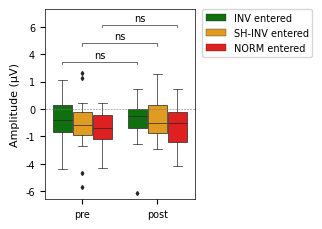

In [8]:
diff_bymap_df_sns_reduced = diff_bymap_df_sns.query('map in ["diff_inv_entered", "diff_shinv_entered", "diff_norm_entered"]')
fig = plt.figure(figsize=(1.5,1.9))
ax = fig.add_axes([0,0,1,1])

hue_order = ['diff_inv_entered', 'diff_shinv_entered', 'diff_norm_entered']

palette = {'diff_inv_entered': 'green', 
        #    'diff_inv_left': 'lightgreen',
            'diff_shinv_entered': 'orange', 
            # 'diff_shinv_left': 'moccasin', 
            'diff_norm_entered': 'red',
        # 'diff_norm_left': 'salmon'
        }

ax = sns.boxplot(diff_bymap_df_sns_reduced, x = 'period', y = 'amp', hue = 'map', 
                 palette=palette, hue_order=hue_order, fliersize=2, linewidth = 0.5)


#annotations
pairs = [(('pre', 'diff_inv_entered'), ('post', 'diff_inv_entered')),
         (('pre', 'diff_shinv_entered'), ('post', 'diff_shinv_entered')),
         (('pre', 'diff_norm_entered'), ('post', 'diff_norm_entered')),
    #    (('pre', 'diff_inv_left'), ('post', 'diff_inv_left')),
    #       (('pre', 'diff_shinv_left'), ('post', 'diff_shinv_left')),
    #        (('pre', 'diff_norm_left'), ('post', 'diff_norm_left')),
         ]
annot = Annotator(ax, pairs, data = diff_bymap_df_sns_reduced, x = 'period', y = 'amp', hue = 'map')
#configure annotator with multiple comparisons correction
annot.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2, 
                fontsize = mpl.rcParams['xtick.labelsize'],
                    line_width = mpl.rcParams['lines.linewidth'],
                comparisons_correction = 'BH')
# annot.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2, fontsize = xtick_fontsize)

# Adjust line thickness by iterating over bracket lines in the annotator
  
annot.apply_and_annotate()

#wrangling the legend
legend_labels = ['INV entered', 'SH-INV entered', 'NORM entered']
# legend_labels = ['INV left', 'SH-INV left', 'NORM left']
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# ax.get_legend().remove()

#formatting
# plt.title(f'FIRSTS - OTHERS diff by map, {time_to_plot}')
plt.xlabel('')
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x * 1e6)}'))  # Convert to µV as integer

# plt.yticks(fontsize=xtick_fontsize)
plt.xticks([0, 1], ['pre', 'post'])  
plt.xlim(-0.5, 1.5)  
plt.ylabel('Amplitude (µV)')
ax.hlines(0,-1, 2, linestyles = '--', color = 'grey', linewidth = 0.4)

plt.savefig(f'./figures/diff_by_map_bar_reduced_{time_to_plot}.svg', transparent=True)

In [9]:
def diff_score_df(data_df, scores_df, sub_col_name, data_columns): 

    """ 
    combines the df with training scores and the df with some participant-specific data to allow corr analyses

    Note: subject is the unformatted column. sub is formatted as strings with leading 0s, e.g. '02'
    power_diff_df: expected columns: sub, diff
    scores_df: exported from training repo with scores from all subjects. Expected columns:  subject, score, musician, rank
    sub_col_name: name of subject column in data df (usually sub or subject)
    data_columns: columns from the data
    ---
    returns diff_df_ranked: df with sub, training score, data of interest, and relative ranking to other subjects
    """

    #configure sub column of scores_df to make it match the column in the diff df
    scores_df['sub'] = scores_df['subject'].astype(int).apply(lambda x: f'{x:02d}')

    #configure data df
    data_df['sub'] = data_df[sub_col_name]
    assert data_df['sub'].apply(lambda x: isinstance(x, str) and len(x) == 2).all(), "Subjects should be expressed as a string with 2 characters"

    data_filt_df = data_df[['sub'] + data_columns]
    data_filt_df.reset_index(drop=True)

    diff_df_ranked = data_filt_df.merge(scores_df, on =['sub'])
    #power_diff_df_ranked = power_diff_df_ranked[['sub', 'diff', 'musician', 'score', 'rank']]

    return diff_df_ranked

## Figure S8: correlation between training score and delta f-o for each keyboard map

/var/folders/jq/t9k2fgpx515flrs5403k2gf80000gn/T/ipykernel_63493/2301528603.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


PearsonRResult(statistic=-0.27744909132624324, pvalue=0.26499065615235995)


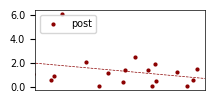

In [10]:

scores_df = pd.read_csv('../utils/training_scores_rank.csv')
map = 'inv'
period = 'post'

diff_to_corr = f'diff_{map}_entered'

corr_df = diff_score_df(diff_bymap_df, scores_df, 'subject', [diff_to_corr, 'period'])

if period == 'pre':
    color = 'darkblue'
    markerfacecolor = 'none' 
elif period == 'post':
    color = 'darkred'
    markerfacecolor = color


#correlation between differences and training performance
corr_df_per = corr_df.query(f'period == "{period}"')

fig = plt.figure(figsize = (1.7, 0.8))
ax = fig.add_axes([0,0,1,1]) 

#plot points
score = corr_df_per['score']
diff = np.abs(corr_df_per[diff_to_corr])

plt.scatter(score, diff, color = color, facecolors = markerfacecolor, label= period)
#pearson corr
print(pearsonr(score, diff))

# Generate the regression line
slope, intercept, r_value, p_value_corr, std_err = stats.linregress(score, diff)
x = np.linspace(0, 4, 100)
y = slope * x + intercept
plt.plot(x, y, linestyle = '--', color = color)

plt.xlim(2,4)
# plt.ylim(0,5.5e-6)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert to µV
plt.xticks([2,3,4], labels= [2,3,4])
plt.xticks([])
plt.yticks()

plt.legend(loc = 'upper left')
plt.tight_layout()
plt.savefig(f'./figures/corr_{diff_to_corr}_{period}_{time_to_plot}.svg', transparent=True)



PearsonRResult(statistic=0.21327972367109216, pvalue=0.3954650632430123)


/var/folders/jq/t9k2fgpx515flrs5403k2gf80000gn/T/ipykernel_63493/2411825710.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


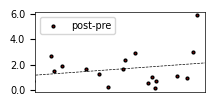

In [11]:
prepost_corr_df = (
    corr_df.groupby('subject')
      .apply(lambda g: abs(g.loc[g['period']=='post', diff_to_corr].values[0]
                         - g.loc[g['period']=='pre',  diff_to_corr].values[0]))
      .reset_index(name='diff_magnitude')
)

prepost_corr_df = prepost_corr_df.merge(corr_df[['subject','score']].drop_duplicates(), on='subject')


fig = plt.figure(figsize = (1.7, 0.8))
ax = fig.add_axes([0,0,1,1]) 


#plot points
score = prepost_corr_df['score']
diff = prepost_corr_df['diff_magnitude']

plt.scatter(score, diff, color = 'black', facecolors = markerfacecolor, label= 'post-pre')
#pearson corr
print(pearsonr(score, diff))

# Generate the regression line
slope, intercept, r_value, p_value_corr, std_err = stats.linregress(score, diff)
x = np.linspace(0, 4, 100)
y = slope * x + intercept
plt.plot(x, y, linestyle = '--', color = 'black')

plt.xlim(2,4)
# plt.ylim(0,5.5e-6)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert to µV
plt.xticks([2,3,4], labels= [2,3,4])
plt.xticks([])
plt.yticks()

plt.legend(loc = 'upper left')
plt.tight_layout()
plt.savefig(f'./figures/corr_{diff_to_corr}_prepost_{time_to_plot}.svg', transparent=True)